In [1]:
import os
import numpy as np
import torch
from nilearn import plotting
import data
import visualize
from words import make_classifications, Predictions
from data import normalize_fmri_data, unnormalize_fmri_data, analyze_results
from LEM import extract_data_features, predAccuracy
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
class argObj:
    def __init__(self, data_dir, parent_submission_dir, subj):
        self.subj = format(subj, '02')
        self.data_dir = os.path.join(data_dir, 'subj' + self.subj)
        self.parent_submission_dir = parent_submission_dir
        self.subject_submission_dir = os.path.join(self.parent_submission_dir,
                                                   'subj' + self.subj)


In [3]:
platform = 'jupyter_notebook'
device = 'cpu'
device = torch.device('cpu')
# setting up the directories and ARGS
data_dir = ''#../MQP/algonauts_2023_challenge_data/'
parent_submission_dir = '../submission'
subj = 4 # @param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
# args

args = argObj(data_dir, parent_submission_dir, subj)
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

words = ['furniture', 'food', 'kitchenware', 'appliance', 'person', 'animal', 'vehicle', 'accessory',
            'electronics', 'sports', 'traffic', 'outdoor', 'home', 'clothing', 'hygiene', 'toy', 'plumbing', 
             'computer', 'fruit', 'vegetable', 'tool']


In [4]:
print("________ Process Data ________")

# Normalize Data Before Split
lh_fmri, lh_data_min, lh_data_max = normalize_fmri_data(lh_fmri)
rh_fmri, rh_data_min, rh_data_max = normalize_fmri_data(rh_fmri)

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

train_img_dir = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir = os.path.join(args.data_dir, 'test_split', 'test_images')
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()

print('\nTraining images: ' + str(len(train_img_list)))
print('\nTest images: ' + str(len(test_img_list)))


________ Process Data ________
LH training fMRI data shape:
(8779, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20544)
(Training stimulus images × RH vertices)

Training images: 8779

Test images: 395


In [5]:
print("________ Split Data ________")

idxs_train, idxs_val, idxs_test = data.splitdata(train_img_list, test_img_list, train_img_dir)
lh_fmri_train = lh_fmri[idxs_train]
rh_fmri_train = rh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_val = rh_fmri[idxs_val]

________ Split Data ________
Training stimulus images: 7901

Validation stimulus images: 878

Test stimulus images: 395


In [6]:
print("________ Make Lists ________")

train_images = data.makeList(train_img_dir, train_img_list, idxs_train)
val_images = data.makeList(train_img_dir, train_img_list, idxs_val)
test_images = data.makeList(test_img_dir, test_img_list, idxs_test)
torch.cuda.empty_cache()

________ Make Lists ________


In [7]:
print("________ Make Classifications ________")
lh_classifications = make_classifications(train_images, idxs_train, device)
rh_classifications = lh_classifications
lh_classifications_val = make_classifications(val_images, idxs_val, device)
rh_classifications_val = lh_classifications_val
lh_classifications_test = make_classifications(test_images, idxs_test, device)
rh_classifications_test = lh_classifications_test
torch.cuda.empty_cache()

________ Make Classifications ________



0: 640x640 1 truck, 1 traffic light, 1: 640x640 1 person, 1 surfboard, 2: 640x640 1 dog, 3: 640x640 5 persons, 2 cars, 1 motorcycle, 3 ties, 4: 640x640 3 persons, 2 cars, 1 sports ball, 1 tennis racket, 5: 640x640 1 microwave, 1 oven, 1 sink, 1 refrigerator, 6: 640x640 1 person, 1 truck, 2 clocks, 7: 640x640 1 person, 1 surfboard, 8: 640x640 5 persons, 4 horses, 9: 640x640 3 persons, 1 skis, 10: 640x640 1 airplane, 11: 640x640 1 bird, 12: 640x640 7 persons, 1 bottle, 1 bowl, 1 hot dog, 13: 640x640 1 person, 1 baseball glove, 1 bowl, 1 sink, 1 scissors, 14: 640x640 1 person, 1 fork, 1 spoon, 1 bowl, 1 laptop, 2 keyboards, 15: 640x640 2 persons, 1 bird, 4 cups, 1 spoon, 5 bowls, 1 carrot, 3 chairs, 3 dining tables, 16: 640x640 5 persons, 2 horses, 2 umbrellas, 17: 640x640 1 traffic light, 18: 640x640 1 toilet, 2 sinks, 19: 640x640 1 airplane, 20: 640x640 1 tv, 2 laptops, 1 mouse, 1 keyboard, 21: 640x640 1 cat, 1 keyboard, 22: 640x640 1 person, 1 frisbee, 23: 640x640 7 persons, 1 bottle,

In [8]:
print("________ Extract Image Features ________")

train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader = (
    data.transformData(train_img_dir, test_img_dir, idxs_train, idxs_val, idxs_test, 64))

features_train, features_val, features_test = (
    extract_data_features(train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader, 64))

________ Extract Image Features ________


Extracting Features: 100%|██████████| 7/7 [01:48<00:00, 15.53s/it]


Training images features:
(7901, 64)
(Training stimulus images × PCA features)

Validation images features:
(878, 64)
(Validation stimulus images × PCA features)

Test images features:
(395, 64)
(Test stimulus images × PCA features)


In [9]:
print("________ Organize Input________")

LH_train_class, LH_train_FMRI = data.organize_input(lh_classifications, features_train, lh_fmri_train)
LH_val_class, LH_val_FMRI = data.organize_input(lh_classifications_val, features_val, lh_fmri_val)    
RH_train_class, RH_train_FMRI = data.organize_input(rh_classifications, features_train, rh_fmri_train)
RH_val_class, RH_val_FMRI = data.organize_input(rh_classifications_val, features_val, rh_fmri_val)


________ Organize Input________


In [10]:
print("________ Predictions Validation ________")

lh_fmri_val_pred = Predictions(LH_train_class, LH_train_FMRI, LH_val_class )
rh_fmri_val_pred = Predictions(RH_train_class, RH_train_FMRI, RH_val_class)
# lh_fmri_test_pred = Predictions(LH_train_class, LH_train_FMRI, LH_test_class )
# rh_fmri_test_pred = Predictions(RH_train_class, RH_train_FMRI, RH_test_class )


________ Predictions Validation ________


In [11]:
print("________ Analyze Results ________")

analyze_results(LH_val_FMRI, lh_fmri_val_pred)
analyze_results(RH_val_FMRI, rh_fmri_val_pred)

________ Analyze Results ________
[array([    0.40301,     0.36582,     0.30934, ...,     0.41659,     0.33289,     0.39192], dtype=float32), array([    0.36688,     0.27086,     0.49033, ...,     0.26821,     0.34538,      0.3082], dtype=float32), array([    0.44363,     0.79069,      0.4933, ...,     0.78108,     0.71501,     0.55573], dtype=float32), array([    0.45493,     0.52817,     0.55562, ...,     0.54296,     0.56121,     0.60827], dtype=float32), array([    0.53356,     0.50533,     0.55331, ...,     0.55281,      0.5344,     0.60834], dtype=float32), array([    0.35354,     0.34871,     0.56684, ...,     0.32997,     0.36759,     0.44965], dtype=float32), array([    0.36685,     0.43945,     0.36156, ...,     0.30165,     0.30638,     0.32566], dtype=float32), array([    0.43326,     0.66949,     0.50593, ...,     0.25375,     0.22852,     0.35287], dtype=float32), array([    0.43548,      0.5116,     0.41469, ...,     0.73104,     0.70948,      0.7631], dtype=float32), ar

In [12]:
print("________ Unnormalize Data ________")

lh_fmri_val_pred = unnormalize_fmri_data(lh_fmri_val_pred, lh_data_min, lh_data_max)
rh_fmri_val_pred = unnormalize_fmri_data(rh_fmri_val_pred, rh_data_min, rh_data_max)

________ Unnormalize Data ________


In [13]:
print("________ Re-Load Data ________")
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_val = rh_fmri[idxs_val]


________ Re-Load Data ________


In [14]:
print("________ Prediction Accuracy ________")

lh_correlation, rh_correlation = predAccuracy(lh_fmri_val_pred, lh_fmri_val, rh_fmri_val_pred, rh_fmri_val)


________ Prediction Accuracy ________
Start PredAccuracy

predicted
 [[   -0.21649    -0.16139    -0.39535 ...    0.011305    0.014551    0.030751]
 [   -0.17825    -0.20714   -0.082977 ...    -0.13471   -0.099602    -0.13769]
 [  -0.056041     0.27044     -0.2381 ...    0.027611    0.055222     0.07379]
 ...
 [    0.10245      1.0585     0.02858 ...     0.50085     0.40748     0.58464]
 [  -0.074726     -0.4043    -0.20885 ...    -0.30986    -0.25188    -0.43878]
 [   -0.18008    -0.15531   -0.058377 ...   -0.075089    -0.06308   -0.071092]] 
actual
 [[   -0.49577    -0.71459     -1.0469 ...    -0.41588    -0.90837    -0.56104]
 [   -0.70836     -1.2733    0.018054 ...     -1.2889    -0.83485     -1.0536]
 [   -0.25673      1.7854    0.035492 ...      1.7288      1.3401     0.40284]
 ...
 [      2.363      1.6628      1.2183 ...     0.79194     0.91056     0.80291]
 [  -0.038406    -0.23345     0.74975 ...     0.52672     0.52024   -0.088831]
 [   -0.24644     -1.9587     0.74114 ... 

100%|██████████| 20544/20544 [00:19<00:00, 1029.11it/s]

average lh  32.10837352631332 average rh  35.702493129181555


________ Visualize Each Class ________
MEAN PRED LH:
 [    0.16847     0.44233     0.26418 ...      0.3601     0.30195     0.40905]
MEAN PRED RH:
 [    0.11056    0.063858    -0.24443 ...     0.16614     0.16864     0.17629]
[    0.16847     0.44233     0.26418 ...      0.3601     0.30195     0.40905]
[    0.11056    0.063858    -0.24443 ...     0.16614     0.16864     0.17629]


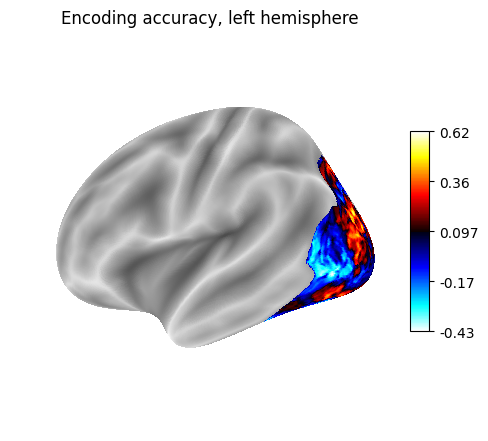

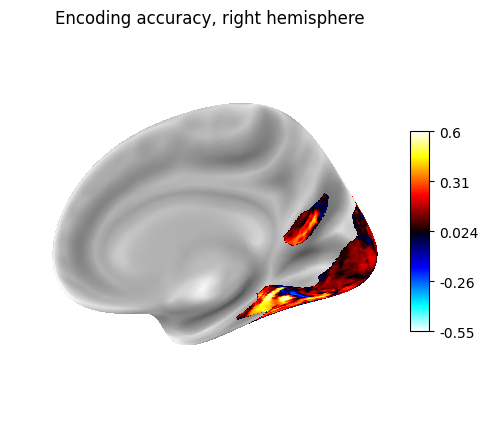

MEAN REAL LH:
 [    0.12808     0.51968      0.3022 ...     0.45213     0.34689     0.51839]
MEAN REAL RH:
 [  -0.093467    0.020922    -0.35489 ...    0.088375     0.12967     0.20832]
[    0.12808     0.51968      0.3022 ...     0.45213     0.34689     0.51839]
[  -0.093467    0.020922    -0.35489 ...    0.088375     0.12967     0.20832]


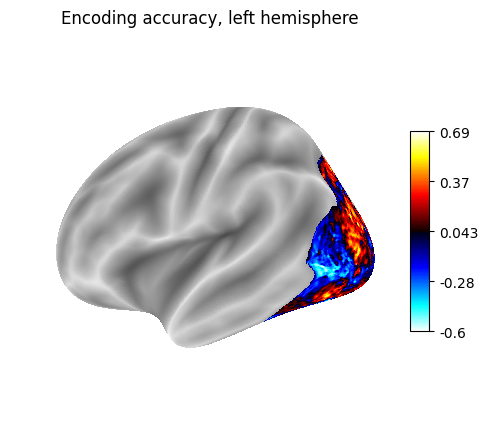

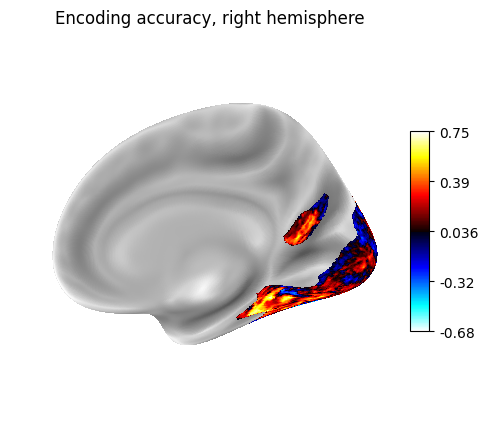

34
Corre  0.21909390780009086
MEAN PRED LH:
 [    0.10624    -0.46375     0.50338 ...    -0.24422    -0.18616     -0.1968]
MEAN PRED RH:
 [    0.23721     0.15176    -0.39764 ...     0.26335     0.28596     0.32822]
[    0.10624    -0.46375     0.50338 ...    -0.24422    -0.18616     -0.1968]
[    0.23721     0.15176    -0.39764 ...     0.26335     0.28596     0.32822]


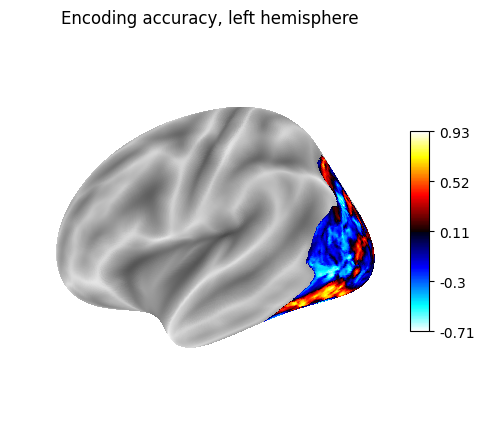

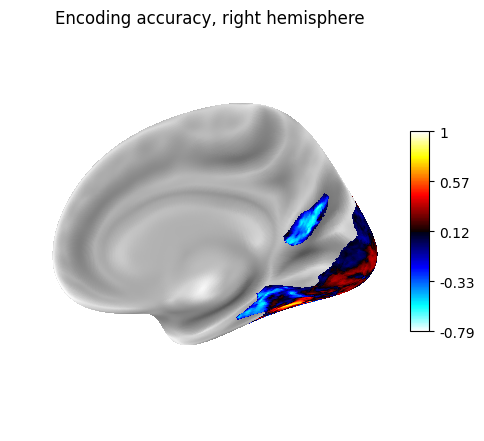

MEAN REAL LH:
 [   0.082844    -0.58809     0.47326 ...    -0.37595    -0.25411    -0.24747]
MEAN REAL RH:
 [    0.51134    0.029481    -0.37804 ...     0.42558     0.32521     0.30979]
[   0.082844    -0.58809     0.47326 ...    -0.37595    -0.25411    -0.24747]
[    0.51134    0.029481    -0.37804 ...     0.42558     0.32521     0.30979]


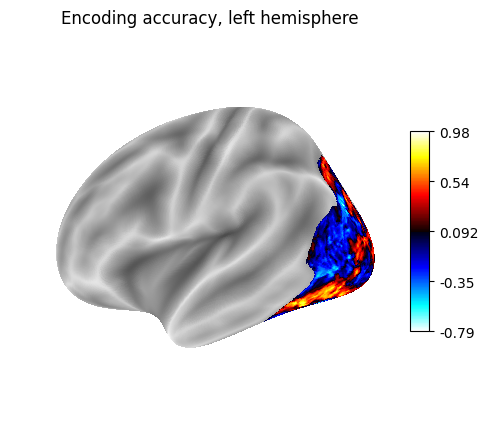

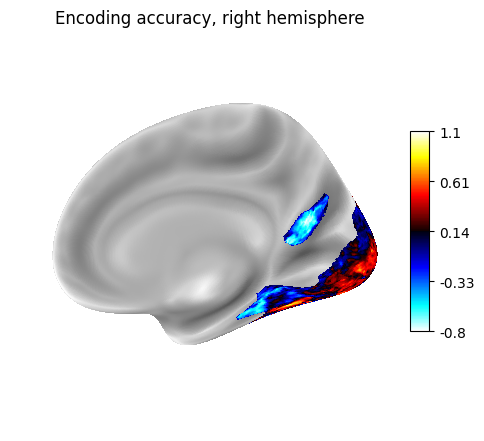

45
Corre  0.36242846557403613
MEAN PRED LH:
 [    0.17072   -0.058002     0.33868 ...     0.05011    0.056655     0.15171]
MEAN PRED RH:
 [    0.18281    0.085388    -0.26293 ...      0.2325     0.24762     0.27972]
[    0.17072   -0.058002     0.33868 ...     0.05011    0.056655     0.15171]
[    0.18281    0.085388    -0.26293 ...      0.2325     0.24762     0.27972]


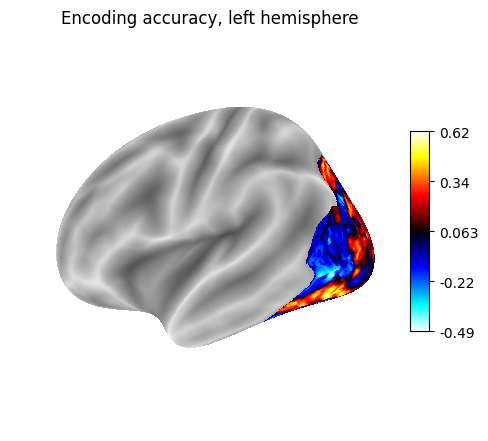

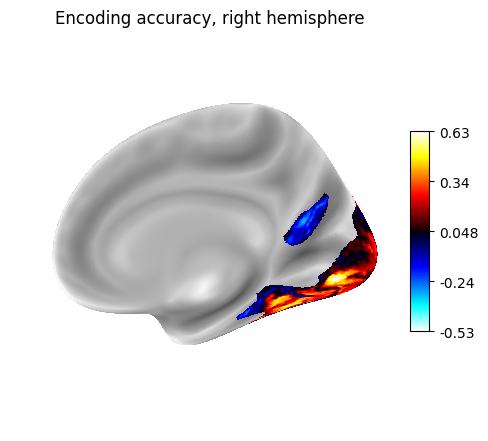

MEAN REAL LH:
 [   0.013939    -0.13967     0.37243 ...    -0.20802     -0.2687    0.071151]
MEAN REAL RH:
 [   0.081671     0.17991    -0.60275 ...     0.11725    0.099245    0.073493]
[   0.013939    -0.13967     0.37243 ...    -0.20802     -0.2687    0.071151]
[   0.081671     0.17991    -0.60275 ...     0.11725    0.099245    0.073493]


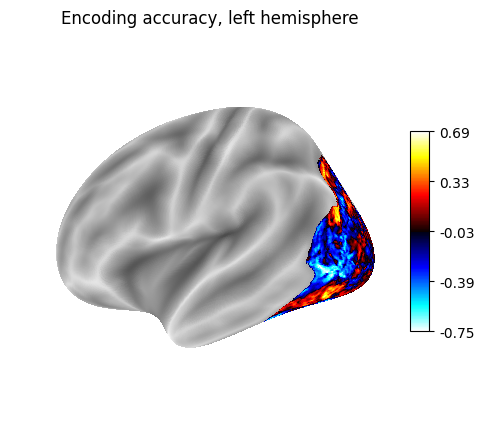

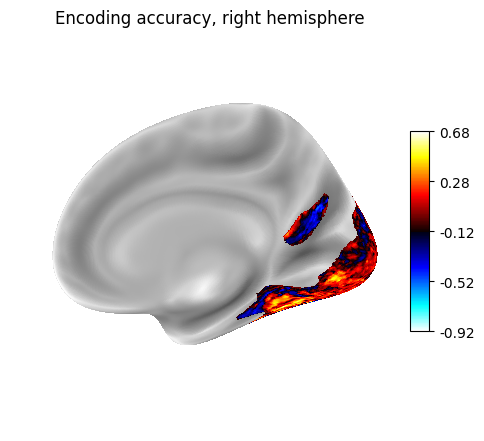

26
Corre  0.22319248131483668
MEAN PRED LH:
 [    0.35117     0.70085     0.26459 ...     0.61635     0.52177     0.65249]
MEAN PRED RH:
 [   -0.12225    0.045075    -0.32306 ...     0.20803     0.25763      0.2827]
[    0.35117     0.70085     0.26459 ...     0.61635     0.52177     0.65249]
[   -0.12225    0.045075    -0.32306 ...     0.20803     0.25763      0.2827]


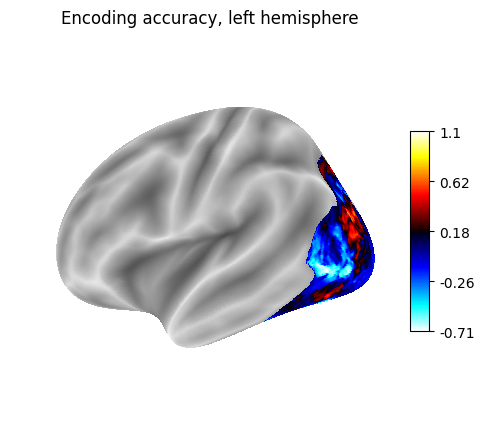

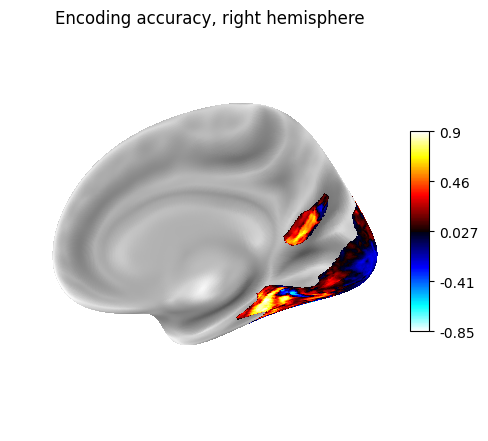

MEAN REAL LH:
 [    0.13093     0.66796     0.28672 ...     0.42136      0.3884     0.45922]
MEAN REAL RH:
 [   -0.31895    0.089442     -0.1798 ...     0.10939     0.15373     0.13992]
[    0.13093     0.66796     0.28672 ...     0.42136      0.3884     0.45922]
[   -0.31895    0.089442     -0.1798 ...     0.10939     0.15373     0.13992]


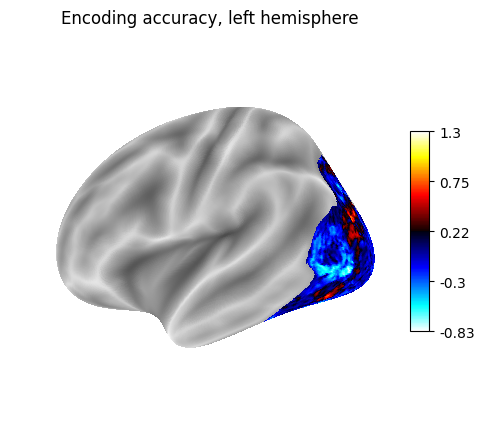

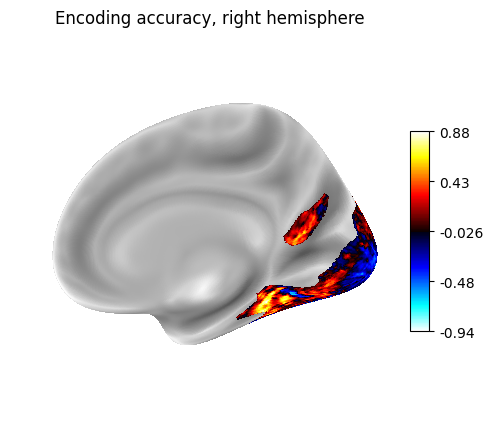

27
Corre  0.3778743899288631
MEAN PRED LH:
 [   -0.12735   -0.046907    -0.22477 ...   -0.083764   -0.073482      -0.123]
MEAN PRED RH:
 [  -0.025204    -0.05234      0.2152 ...   -0.094267    -0.12021    -0.12279]
[   -0.12735   -0.046907    -0.22477 ...   -0.083764   -0.073482      -0.123]
[  -0.025204    -0.05234      0.2152 ...   -0.094267    -0.12021    -0.12279]


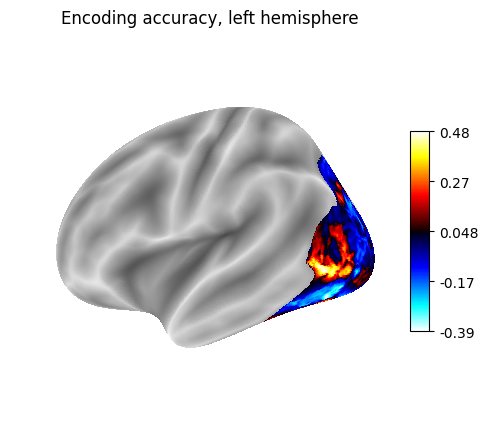

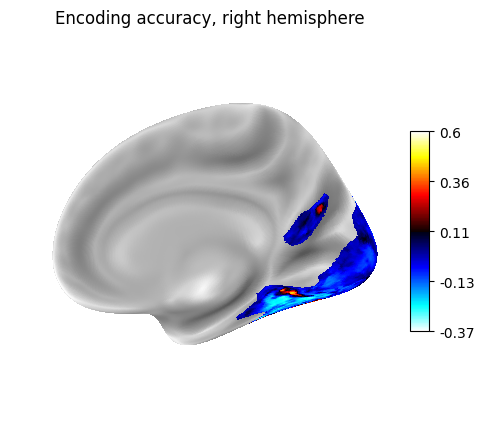

MEAN REAL LH:
 [  -0.061245   -0.010416    -0.22895 ...   -0.010604   0.0097653   -0.030755]
MEAN REAL RH:
 [  -0.017215   0.0074845     0.26569 ...   -0.088283    -0.11013    -0.11227]
[  -0.061245   -0.010416    -0.22895 ...   -0.010604   0.0097653   -0.030755]
[  -0.017215   0.0074845     0.26569 ...   -0.088283    -0.11013    -0.11227]


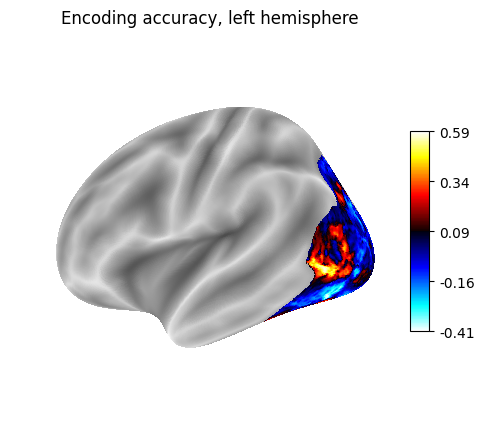

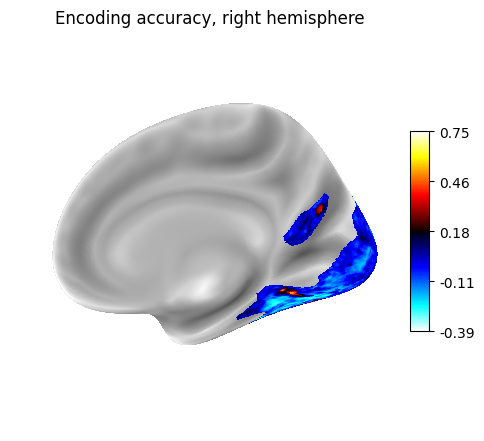

271
Corre  0.10150578294824598
MEAN PRED LH:
 [  0.0055829    -0.24377   -0.026194 ...    -0.15774    -0.12416    -0.16832]
MEAN PRED RH:
 [  -0.026967   -0.044542    0.021714 ...   -0.026678   -0.043373   -0.036335]
[  0.0055829    -0.24377   -0.026194 ...    -0.15774    -0.12416    -0.16832]
[  -0.026967   -0.044542    0.021714 ...   -0.026678   -0.043373   -0.036335]


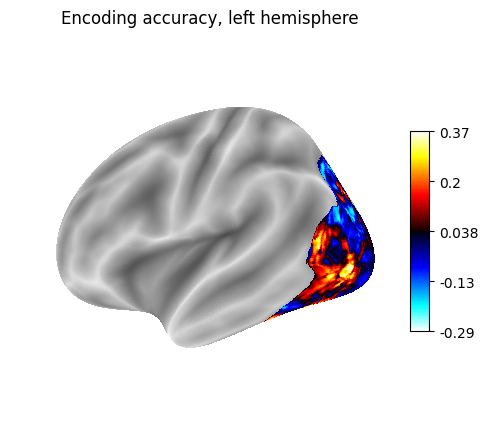

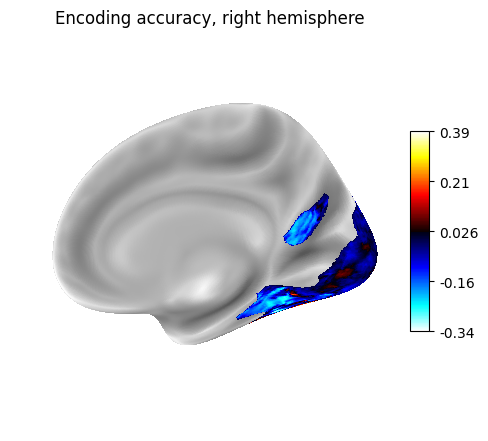

MEAN REAL LH:
 [   0.033191    -0.14394  -0.0089696 ...    -0.14743     -0.1487    -0.17898]
MEAN REAL RH:
 [  0.0085115  0.00051495    0.024575 ...   -0.021401   -0.063903   -0.076969]
[   0.033191    -0.14394  -0.0089696 ...    -0.14743     -0.1487    -0.17898]
[  0.0085115  0.00051495    0.024575 ...   -0.021401   -0.063903   -0.076969]


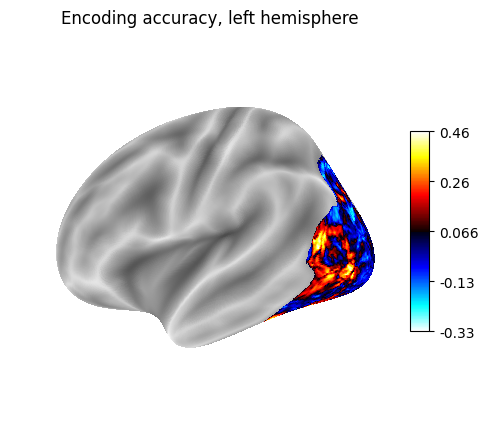

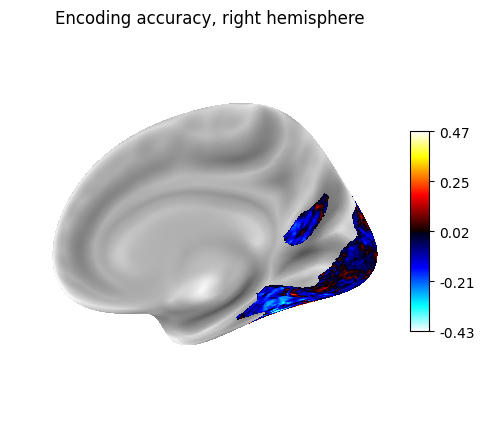

156
Corre  0.0829715805176025
MEAN PRED LH:
 [   0.026284     0.29043    0.093697 ...     0.22768     0.20028     0.24538]
MEAN PRED RH:
 [    0.01401   -0.020783    0.003855 ...   -0.030585  -0.0033389   -0.053044]
[   0.026284     0.29043    0.093697 ...     0.22768     0.20028     0.24538]
[    0.01401   -0.020783    0.003855 ...   -0.030585  -0.0033389   -0.053044]


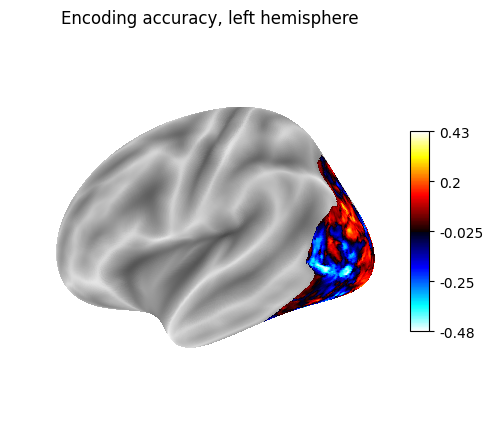

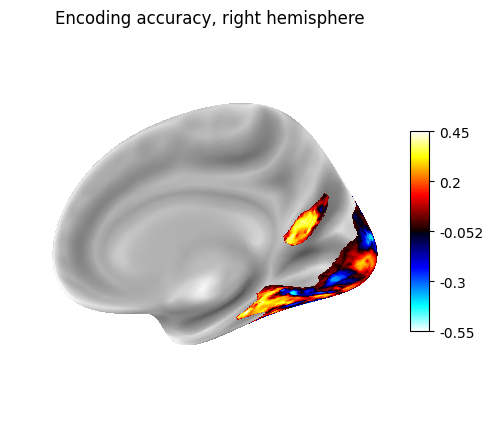

MEAN REAL LH:
 [  -0.011356     0.37296    0.050182 ...     0.21442     0.15572     0.27696]
MEAN REAL RH:
 [  -0.035226    0.057904   -0.052763 ...   -0.017406   -0.036404    -0.11646]
[  -0.011356     0.37296    0.050182 ...     0.21442     0.15572     0.27696]
[  -0.035226    0.057904   -0.052763 ...   -0.017406   -0.036404    -0.11646]


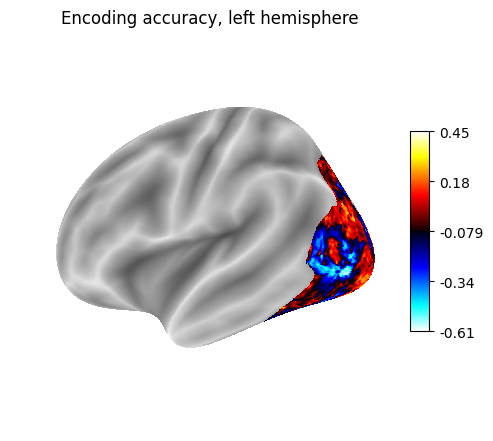

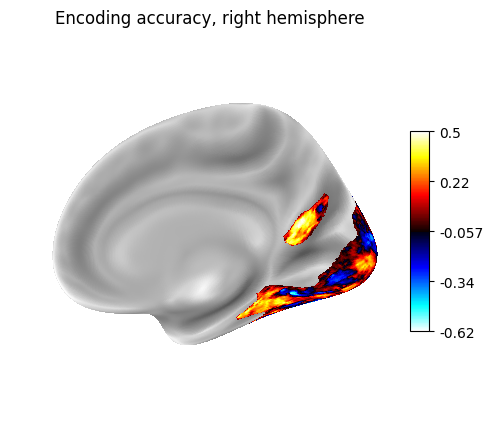

101
Corre  0.16010410640392533
MEAN PRED LH:
 [  -0.096931      0.3607    0.076443 ...     0.41802     0.37176       0.464]
MEAN PRED RH:
 [   -0.10837   -0.059727     0.15526 ...    0.024354    0.070601    0.077356]
[  -0.096931      0.3607    0.076443 ...     0.41802     0.37176       0.464]
[   -0.10837   -0.059727     0.15526 ...    0.024354    0.070601    0.077356]


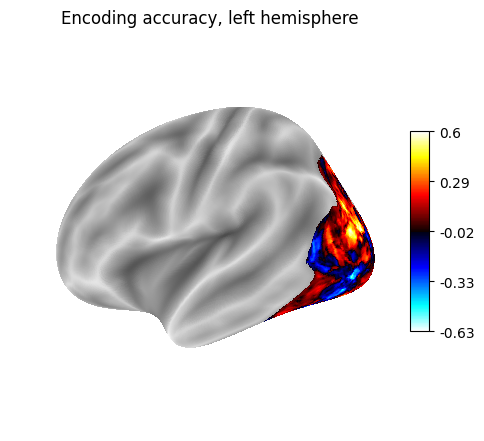

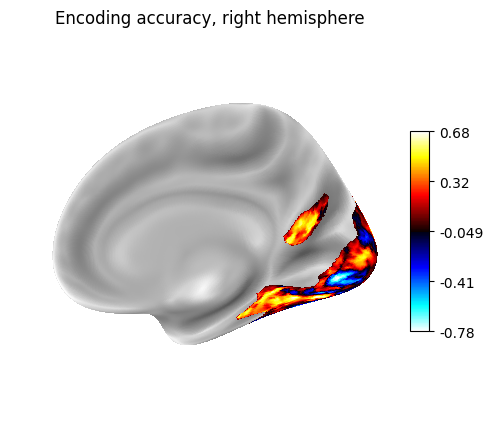

MEAN REAL LH:
 [   -0.15133     0.56228     0.25367 ...     0.04821     0.17387     0.34701]
MEAN REAL RH:
 [   -0.27238    -0.44108    -0.27002 ...   -0.023436     0.20604     0.32114]
[   -0.15133     0.56228     0.25367 ...     0.04821     0.17387     0.34701]
[   -0.27238    -0.44108    -0.27002 ...   -0.023436     0.20604     0.32114]


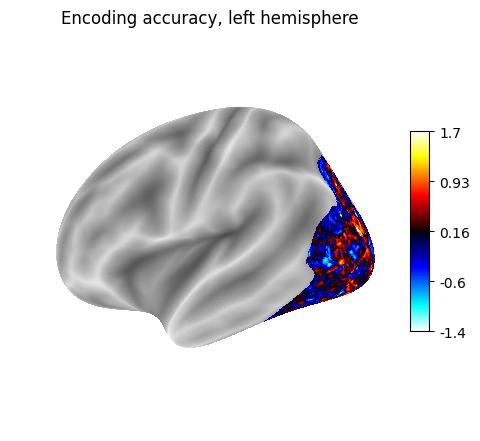

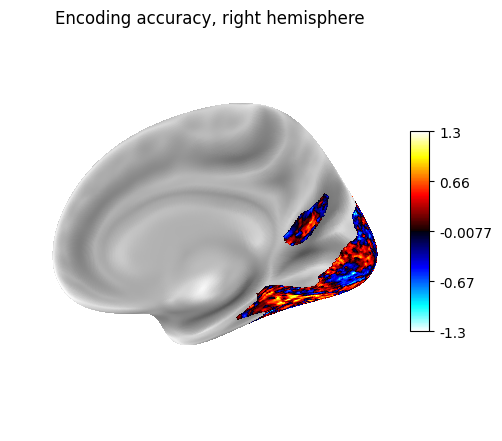

3
Corre  0.34745936059304006
MEAN PRED LH:
 [    0.27197     0.47271      0.1286 ...     0.41743     0.35096     0.44291]
MEAN PRED RH:
 [   0.044369    0.039934    -0.28999 ...     0.10607     0.12456     0.14975]
[    0.27197     0.47271      0.1286 ...     0.41743     0.35096     0.44291]
[   0.044369    0.039934    -0.28999 ...     0.10607     0.12456     0.14975]


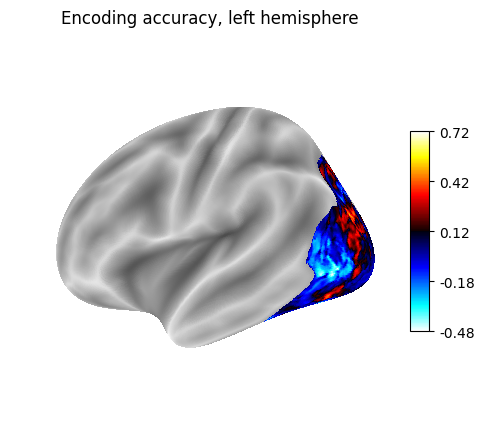

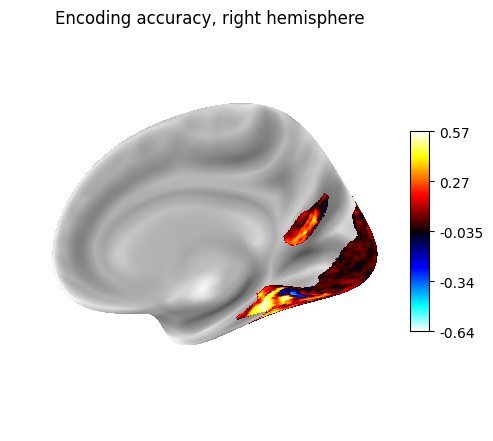

MEAN REAL LH:
 [    0.17563     0.27756     0.15173 ...     0.40363     0.34567     0.52383]
MEAN REAL RH:
 [    0.15654    -0.15408    -0.30732 ...    0.099646     0.14008     0.24701]
[    0.17563     0.27756     0.15173 ...     0.40363     0.34567     0.52383]
[    0.15654    -0.15408    -0.30732 ...    0.099646     0.14008     0.24701]


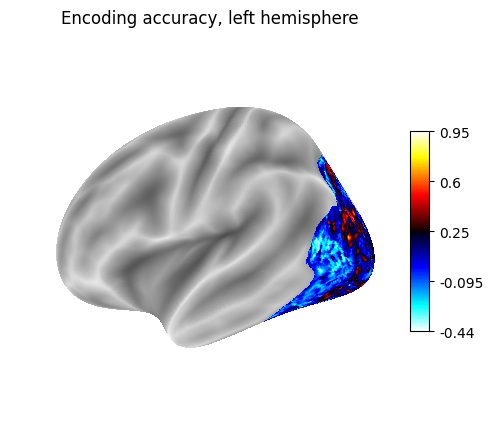

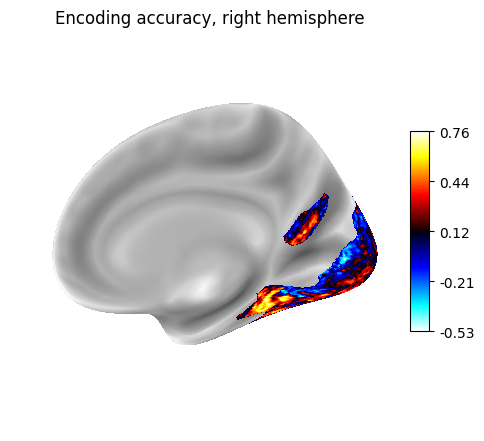

21
Corre  0.19473450513808108
MEAN PRED LH:
 [  -0.092121    -0.29696    -0.13823 ...    -0.25492    -0.19727    -0.26602]
MEAN PRED RH:
 [  -0.091475   -0.042371     0.17837 ...   -0.056178   -0.078574   -0.075563]
[  -0.092121    -0.29696    -0.13823 ...    -0.25492    -0.19727    -0.26602]
[  -0.091475   -0.042371     0.17837 ...   -0.056178   -0.078574   -0.075563]


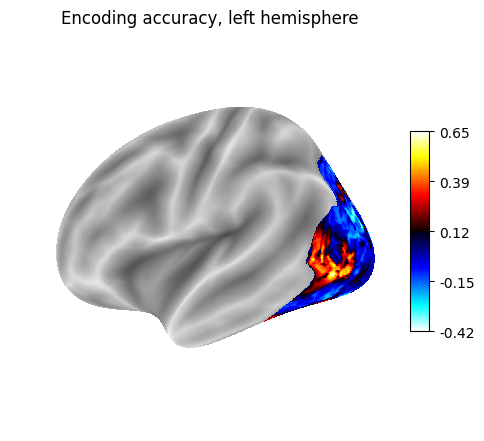

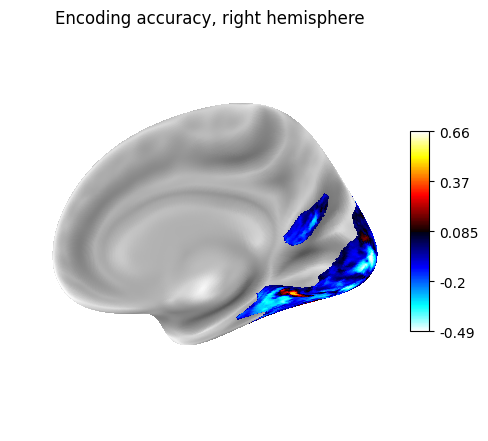

MEAN REAL LH:
 [   -0.10861    -0.52546    -0.39048 ...    -0.29717    -0.21033    -0.46599]
MEAN REAL RH:
 [ -0.0074206    -0.13328     0.10949 ...    -0.22264    -0.30727     -0.3163]
[   -0.10861    -0.52546    -0.39048 ...    -0.29717    -0.21033    -0.46599]
[ -0.0074206    -0.13328     0.10949 ...    -0.22264    -0.30727     -0.3163]


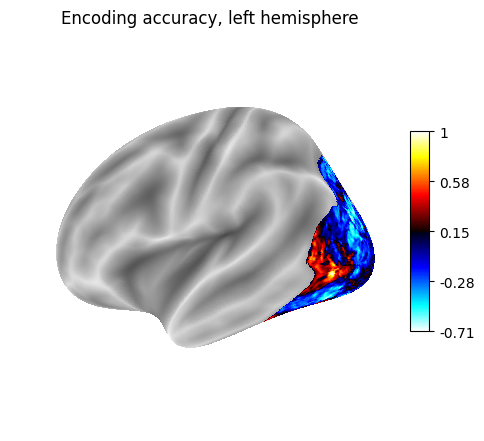

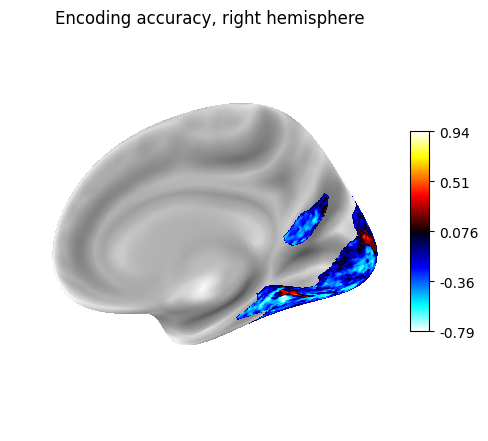

32
Corre  0.1867058697430436
MEAN PRED LH:
 [    0.13456     0.22844     0.23063 ...     0.23085     0.21294     0.24651]
MEAN PRED RH:
 [  0.0039144    -0.10376    -0.15834 ...   0.0070463      0.0629    0.089225]
[    0.13456     0.22844     0.23063 ...     0.23085     0.21294     0.24651]
[  0.0039144    -0.10376    -0.15834 ...   0.0070463      0.0629    0.089225]


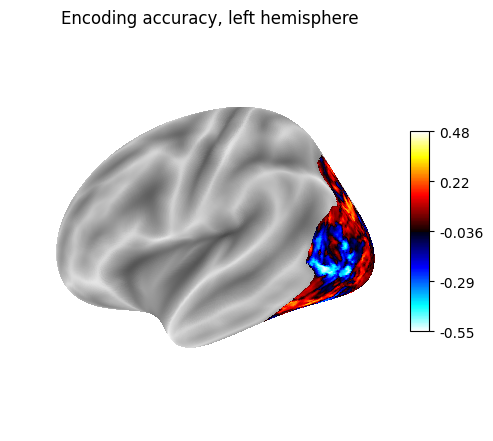

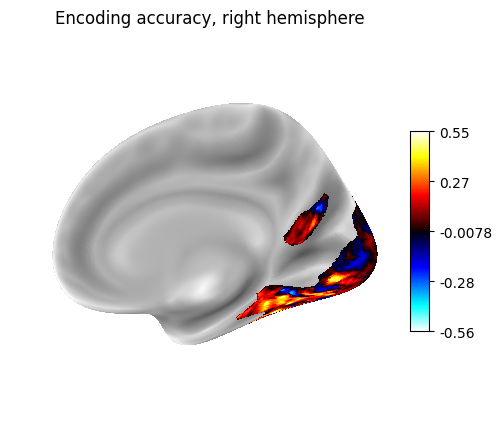

MEAN REAL LH:
 [  0.0010554     0.41377     0.35151 ...     0.28682     0.24132     0.51408]
MEAN REAL RH:
 [   -0.18236     0.05318   -0.058584 ...     0.10528     0.18436     0.33526]
[  0.0010554     0.41377     0.35151 ...     0.28682     0.24132     0.51408]
[   -0.18236     0.05318   -0.058584 ...     0.10528     0.18436     0.33526]


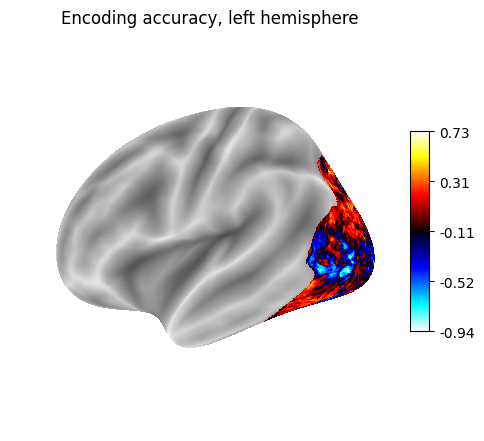

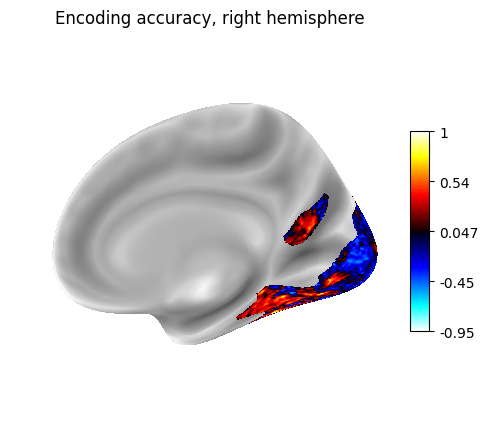

19
Corre  0.20867139688536243
MEAN PRED LH:
 [  0.0083099     0.19038   -0.036164 ...      0.1779     0.13066     0.19754]
MEAN PRED RH:
 [  -0.059864    -0.12026    0.017749 ...    0.022432    0.041562    0.034587]
[  0.0083099     0.19038   -0.036164 ...      0.1779     0.13066     0.19754]
[  -0.059864    -0.12026    0.017749 ...    0.022432    0.041562    0.034587]


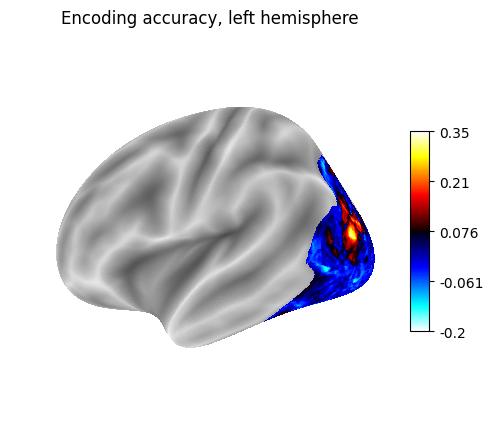

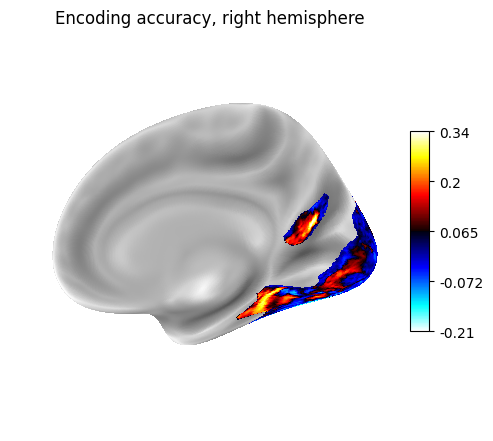

MEAN REAL LH:
 [   0.011592       0.346     0.18303 ...     0.26659     0.20433     0.30894]
MEAN REAL RH:
 [  -0.028343   -0.021727    -0.04033 ...    0.083498     0.14611   -0.021468]
[   0.011592       0.346     0.18303 ...     0.26659     0.20433     0.30894]
[  -0.028343   -0.021727    -0.04033 ...    0.083498     0.14611   -0.021468]


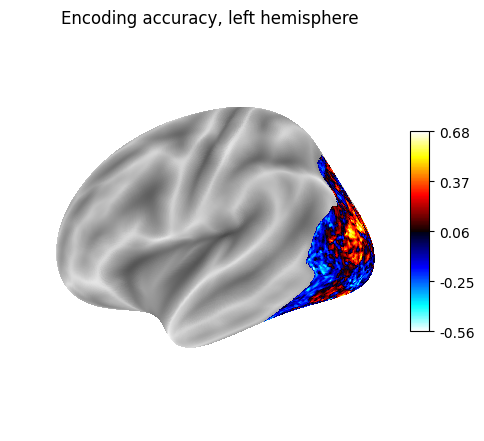

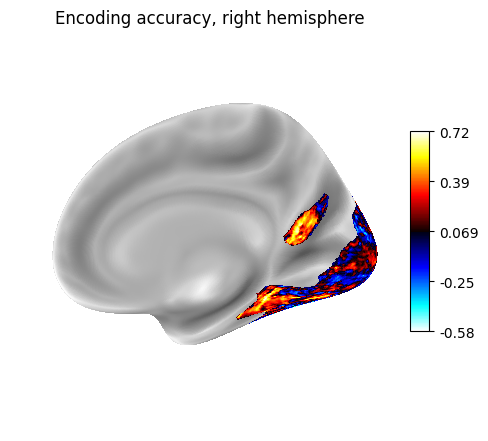

15
Corre  0.09634883221391262
MEAN PRED LH:
 [    0.21194       0.385     0.29485 ...     0.24207     0.21355     0.28829]
MEAN PRED RH:
 [   0.054556   -0.022237    -0.19757 ...     0.08193     0.11995     0.12218]
[    0.21194       0.385     0.29485 ...     0.24207     0.21355     0.28829]
[   0.054556   -0.022237    -0.19757 ...     0.08193     0.11995     0.12218]


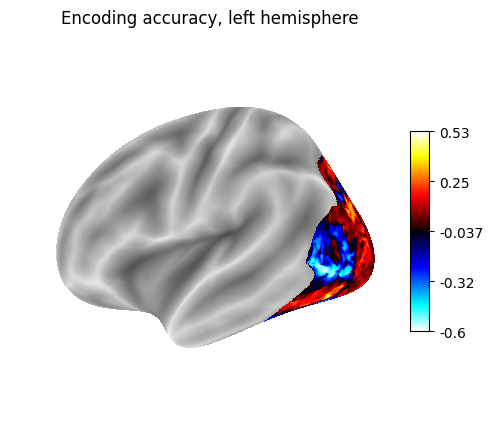

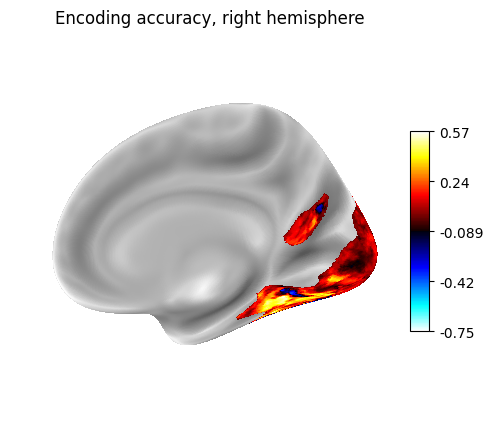

MEAN REAL LH:
 [    0.32534     0.59929     0.14545 ...     0.32841     0.28546     0.43533]
MEAN REAL RH:
 [    0.20614     0.18606   -0.034094 ...   -0.030418    0.016484   -0.033864]
[    0.32534     0.59929     0.14545 ...     0.32841     0.28546     0.43533]
[    0.20614     0.18606   -0.034094 ...   -0.030418    0.016484   -0.033864]


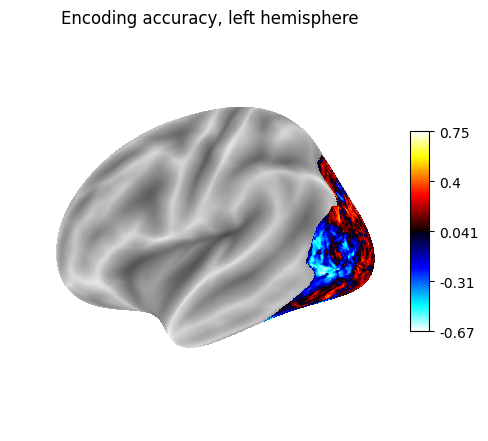

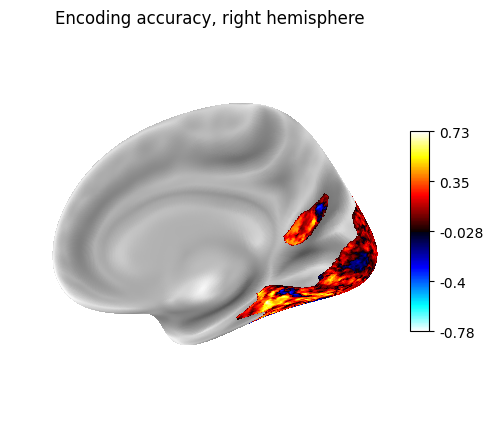

40
Corre  0.22040748490837855
MEAN PRED LH:
 [    0.24418    -0.19927    -0.13964 ...    -0.13026    -0.10492    -0.20946]
MEAN PRED RH:
 [   0.026557     0.06235    0.053185 ...  -0.0033292   -0.017089    0.020024]
[    0.24418    -0.19927    -0.13964 ...    -0.13026    -0.10492    -0.20946]
[   0.026557     0.06235    0.053185 ...  -0.0033292   -0.017089    0.020024]


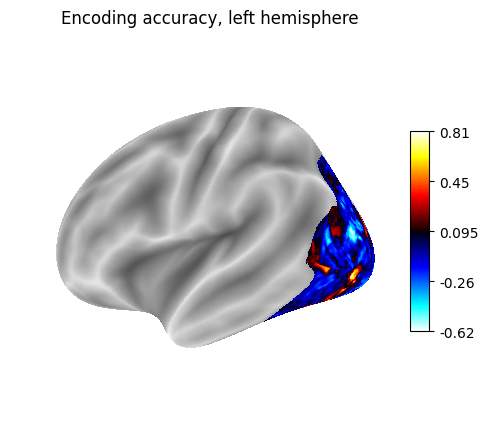

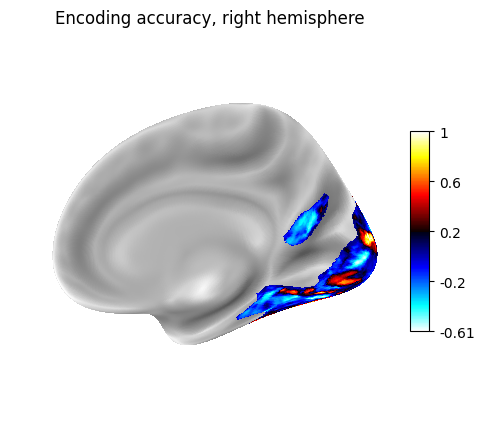

MEAN REAL LH:
 [    0.69782    0.067531      1.0714 ...     0.23291    0.022718     0.54371]
MEAN REAL RH:
 [    0.64431    -0.11874      0.3262 ...    -0.54574    -0.29782   -0.017872]
[    0.69782    0.067531      1.0714 ...     0.23291    0.022718     0.54371]
[    0.64431    -0.11874      0.3262 ...    -0.54574    -0.29782   -0.017872]


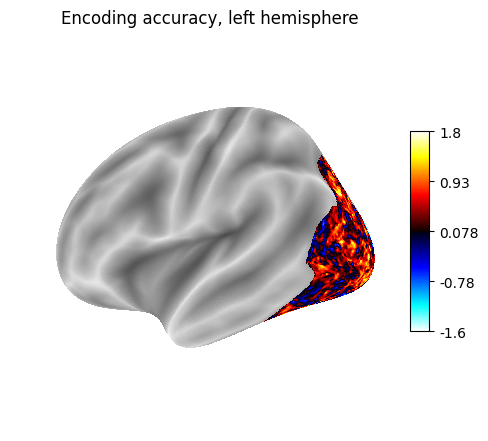

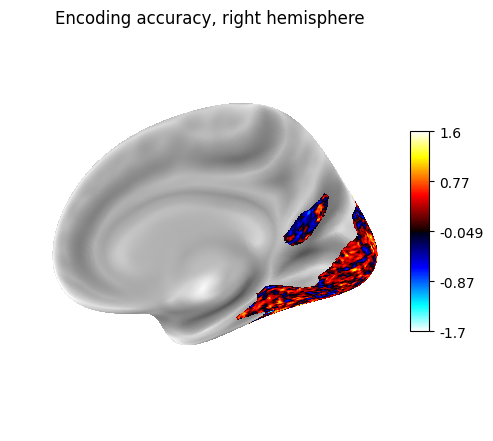

2
Corre  0.2523596158877077
MEAN PRED LH:
 [    0.11983    -0.34111     0.19477 ...    -0.17906    -0.13515     -0.1778]
MEAN PRED RH:
 [  0.0055235   -0.038497    -0.11471 ...    0.092222    0.095841     0.16194]
[    0.11983    -0.34111     0.19477 ...    -0.17906    -0.13515     -0.1778]
[  0.0055235   -0.038497    -0.11471 ...    0.092222    0.095841     0.16194]


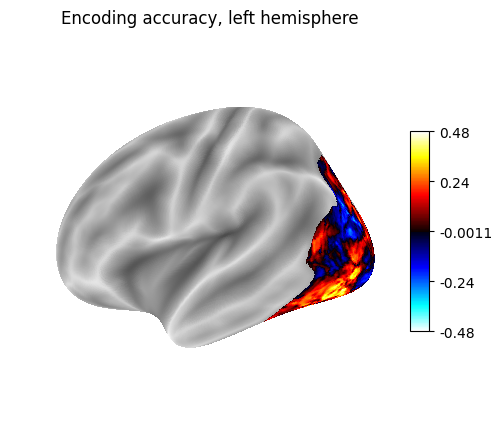

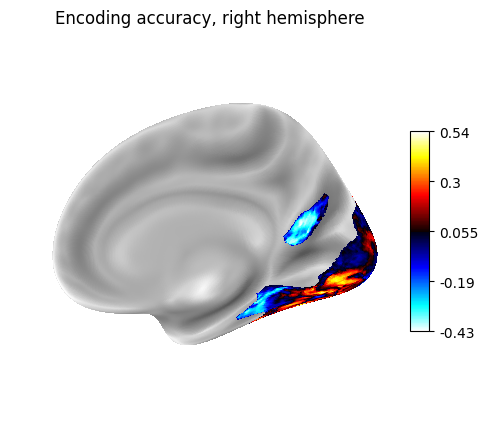

MEAN REAL LH:
 [   0.063942    -0.16607    0.084681 ...    -0.18333    -0.14617    -0.22928]
MEAN REAL RH:
 [  0.0023527    0.008771    -0.12497 ...    0.070492     0.18718     0.13042]
[   0.063942    -0.16607    0.084681 ...    -0.18333    -0.14617    -0.22928]
[  0.0023527    0.008771    -0.12497 ...    0.070492     0.18718     0.13042]


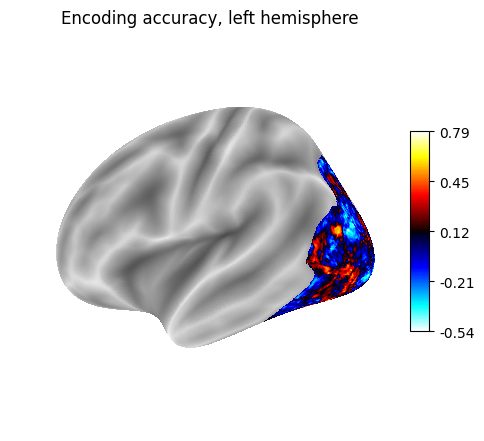

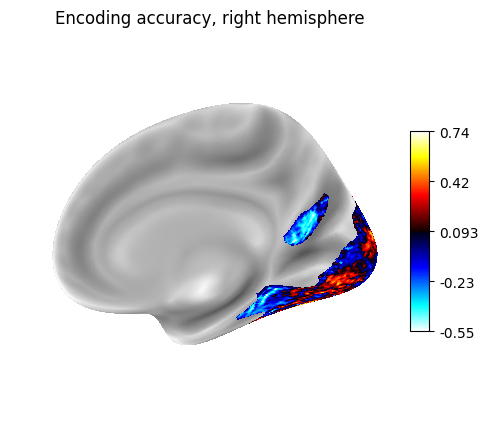

23
Corre  0.14291785563871665
MEAN PRED LH:
 [     0.3025     0.53011     0.20167 ...     0.58042     0.48364     0.63492]
MEAN PRED RH:
 [   -0.26741   -0.034754    -0.30444 ...     0.27131     0.33568      0.3942]
[     0.3025     0.53011     0.20167 ...     0.58042     0.48364     0.63492]
[   -0.26741   -0.034754    -0.30444 ...     0.27131     0.33568      0.3942]


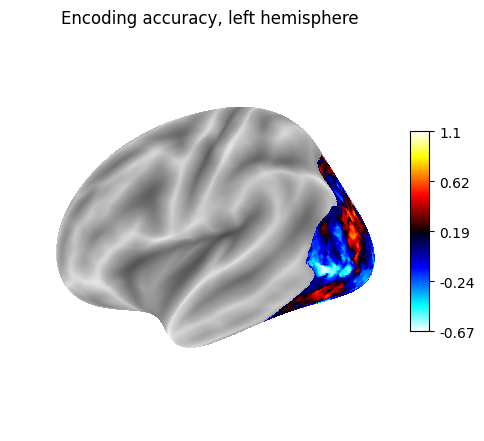

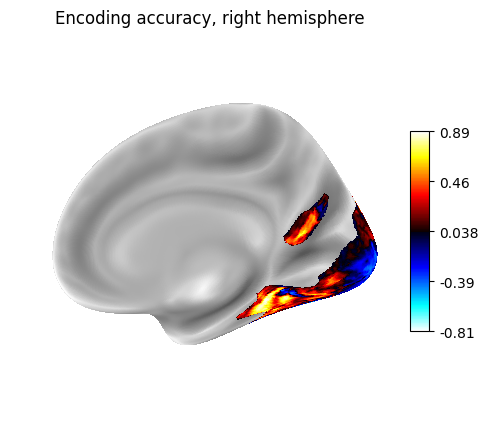

MEAN REAL LH:
 [    0.36108     0.69465     0.20623 ...       0.692     0.46207      0.6455]
MEAN REAL RH:
 [   -0.22445     0.18321     -0.2694 ...     0.26433     0.21587     0.18263]
[    0.36108     0.69465     0.20623 ...       0.692     0.46207      0.6455]
[   -0.22445     0.18321     -0.2694 ...     0.26433     0.21587     0.18263]


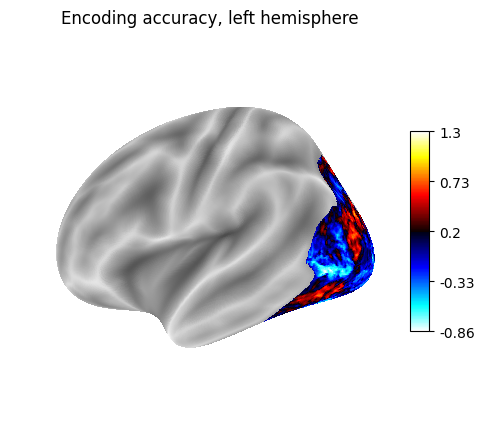

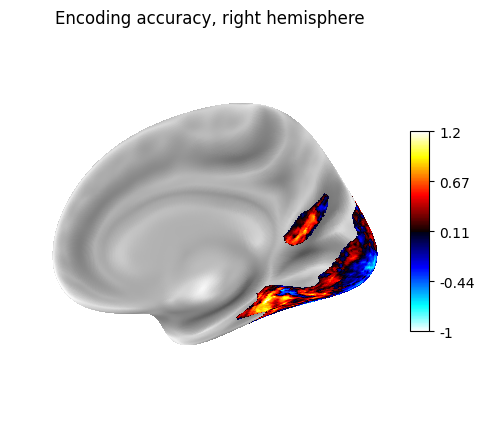

23
Corre  0.4399532668600589
MEAN PRED LH:
 [   0.025819     -0.5435     0.25053 ...    -0.22025    -0.18177    -0.25617]
MEAN PRED RH:
 [    0.18995   -0.078611   -0.092115 ...     0.13133     0.08271      0.1018]
[   0.025819     -0.5435     0.25053 ...    -0.22025    -0.18177    -0.25617]
[    0.18995   -0.078611   -0.092115 ...     0.13133     0.08271      0.1018]


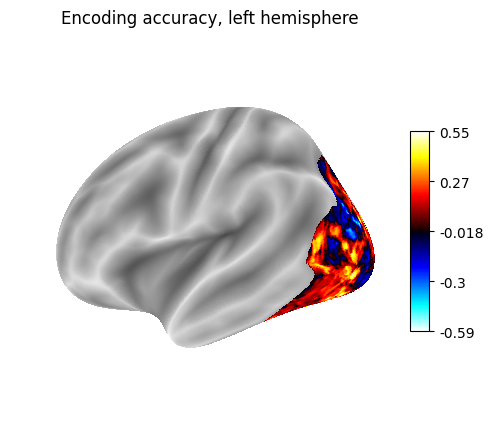

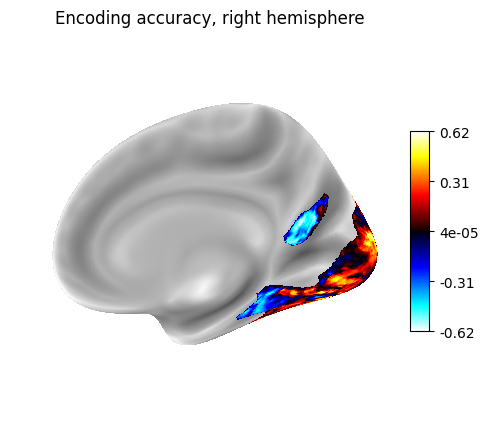

MEAN REAL LH:
 [    0.24295    -0.26505      0.8533 ...     0.35937       0.312     0.44587]
MEAN REAL RH:
 [  -0.062796     0.96557    -0.00586 ...      1.3427        1.38      1.2584]
[    0.24295    -0.26505      0.8533 ...     0.35937       0.312     0.44587]
[  -0.062796     0.96557    -0.00586 ...      1.3427        1.38      1.2584]


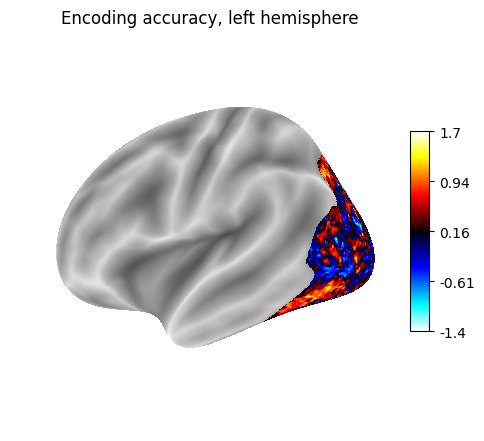

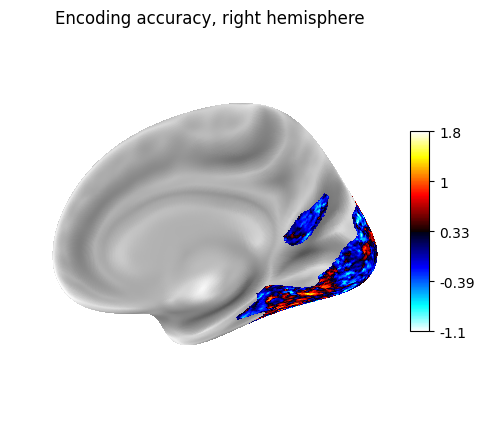

2
Corre  0.4182483407418873
MEAN PRED LH:
 [    0.17038     0.45491     0.19995 ...     0.62826     0.54809       0.691]
MEAN PRED RH:
 [  -0.015223    0.031792    -0.30603 ...     0.18125     0.25344     0.28722]
[    0.17038     0.45491     0.19995 ...     0.62826     0.54809       0.691]
[  -0.015223    0.031792    -0.30603 ...     0.18125     0.25344     0.28722]


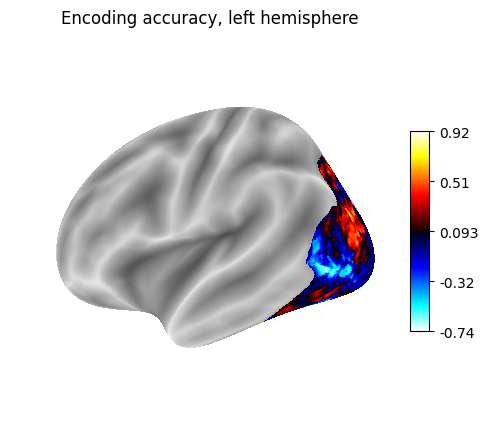

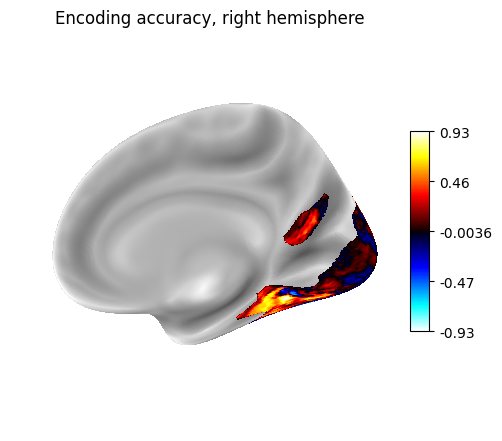

MEAN REAL LH:
 [     1.0602    0.041637     0.95962 ...     0.85723     0.58928      1.1082]
MEAN REAL RH:
 [    0.11716    0.068124     -1.0864 ...      0.6505     0.68196     0.75206]
[     1.0602    0.041637     0.95962 ...     0.85723     0.58928      1.1082]
[    0.11716    0.068124     -1.0864 ...      0.6505     0.68196     0.75206]


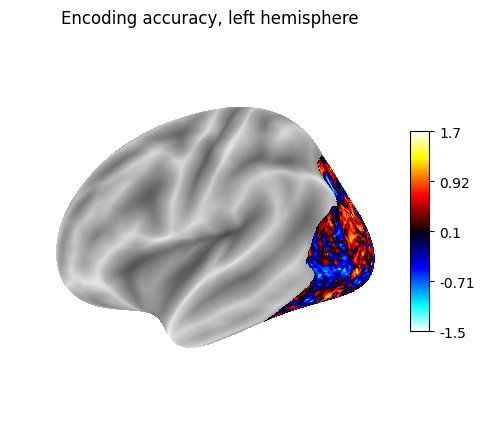

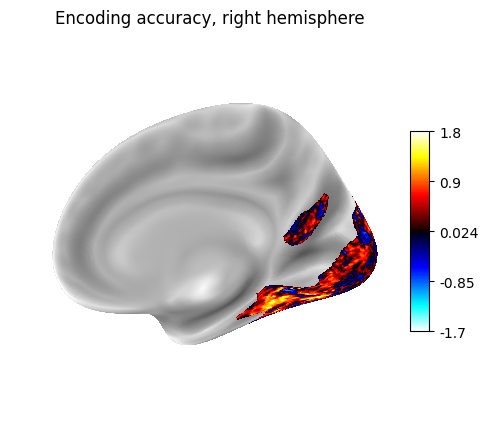

3
Corre  0.4781849344908463
MEAN PRED LH:
 [      0.182    -0.69719     0.46161 ...    -0.28094    -0.21045    -0.18154]
MEAN PRED RH:
 [    0.22824    0.061415    -0.34949 ...     0.32478     0.35884     0.42569]
[      0.182    -0.69719     0.46161 ...    -0.28094    -0.21045    -0.18154]
[    0.22824    0.061415    -0.34949 ...     0.32478     0.35884     0.42569]


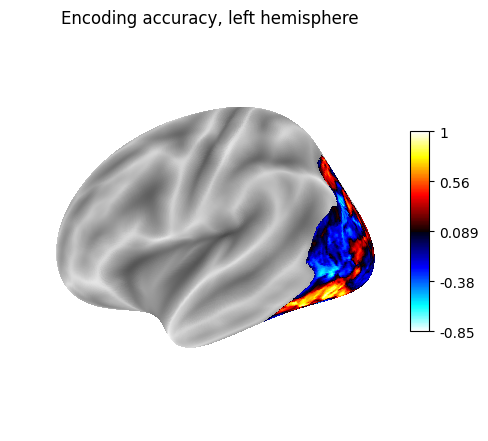

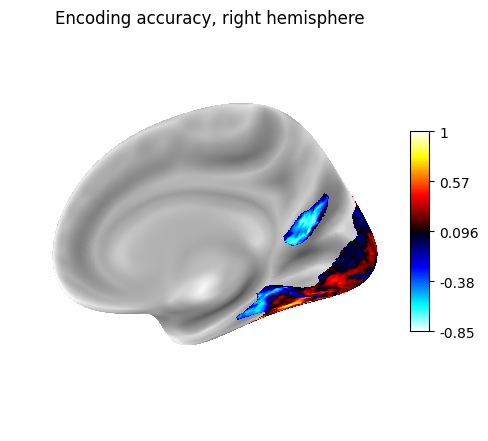

MEAN REAL LH:
 [  -0.088246    -0.39503     0.44274 ...    -0.45932     -0.4117    -0.14163]
MEAN REAL RH:
 [    0.42788    0.038989     -0.5479 ...     0.56066     0.52029     0.48275]
[  -0.088246    -0.39503     0.44274 ...    -0.45932     -0.4117    -0.14163]
[    0.42788    0.038989     -0.5479 ...     0.56066     0.52029     0.48275]


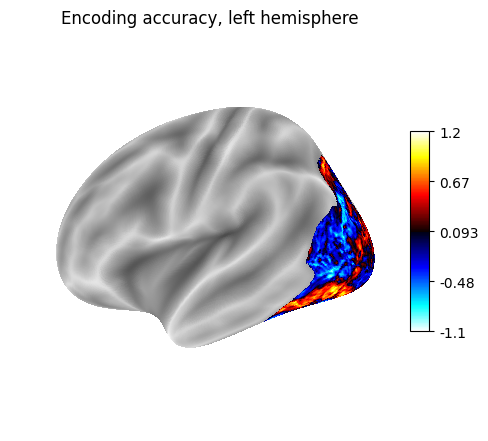

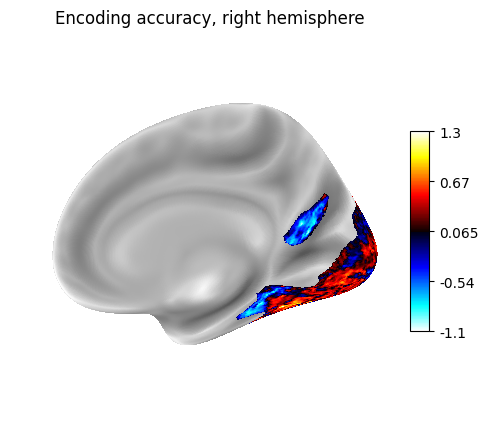

12
Corre  0.4698650681956072
________ END ________


In [15]:
print("________ Visualize Each Class ________")

length = len(words)
for clss in range(length):
    avg_lh_pred = []
    avg_lh_real = []
    avg_rh_pred = []
    avg_rh_real = []
    for i in range(len(lh_classifications_val)):

        if lh_classifications_val[i][1] == clss:
            avg_lh_pred.append(lh_fmri_val_pred[i])
            avg_lh_real.append(lh_fmri_val[i])

        if rh_classifications_val[i][1] == clss:
            avg_rh_pred.append(rh_fmri_val_pred[i])
            avg_rh_real.append(rh_fmri_val[i])
    # Only look at classes that are observed 
    if(len(avg_lh_pred) < 10):
        pass
    else:
        print(words[clss])
        lh = np.mean(avg_lh_pred, axis=0)
        rh = np.mean(avg_rh_pred, axis=0)
        print("MEAN PRED LH:\n", lh)
        print("MEAN PRED RH:\n", rh)
        visualize.plot_predictions(args, lh, rh, 'left')
        visualize.plot_predictions(args, lh, rh, 'right')
        plotting.show()
        lh2 = np.mean(avg_lh_real, axis=0)
        rh2 = np.mean(avg_rh_real, axis=0)
        print("MEAN REAL LH:\n", lh2)
        print("MEAN REAL RH:\n", rh2)
        visualize.plot_predictions(args, lh2, rh2, 'left')
        visualize.plot_predictions(args, lh2, rh2, 'right')
        plotting.show()
        corr = np.corrcoef(avg_lh_pred, avg_lh_real)
        print(len(avg_lh_pred))
        print("Corre ", np.mean(corr))

print("________ END ________")